In [1]:
#Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv("data/GoalData.csv")
print(df.head)

<bound method NDFrame.head of      Wk  Day        Date           Time           Home  HomexG Score  AwayxG  \
0     1  Fri  2023-08-11  20:00 (14:00)        Burnley     0.3   0–3     1.9   
1     1  Sat  2023-08-12  12:30 (06:30)        Arsenal     0.8   2–1     1.2   
2     1  Sat  2023-08-12  15:00 (09:00)        Everton     2.7   0–1     1.5   
3     1  Sat  2023-08-12  15:00 (09:00)  Sheffield Utd     0.5   0–1     1.9   
4     1  Sat  2023-08-12  15:00 (09:00)       Brighton     4.0   4–1     1.5   
..   ..  ...         ...            ...            ...     ...   ...     ...   
273  28  Sun  2024-03-10  13:00 (08:00)    Aston Villa     0.8   0–4     1.5   
274  28  Sun  2024-03-10  14:00 (09:00)       West Ham     2.1   2–2     0.7   
275  28  Sun  2024-03-10  14:00 (09:00)       Brighton     0.4   1–0     0.7   
276  28  Sun  2024-03-10  15:45 (10:45)      Liverpool     2.7   1–1     1.6   
277  28  Mon  2024-03-11  20:00 (15:00)        Chelsea     1.6   3–2     0.7   

         

Data Pre-Processing

In [3]:
def gather_home_goals(value):
    if value != None:
        return int(value[0])
    pass

def gather_away_goals(value):
    if value != None:
        return int(value[2])
    
def gather_winner(value):
    if(value!=None):
        if(int(value[0]) > int(value[2])):
            return 'H'
        elif(int(value[2])>int(value[0])):
            return "A"
        return 'T'

def gather_home_winner(value):
    if(value!=None):
        if(value == 'H'):
            return 1
        return 0
    
def gather_away_winner(value):
    if(value!=None):
        if(value == 'A'):
            return 1
        return 0

df['HomeG'] = df['Score'].apply(lambda x: gather_home_goals(x))
df['AwayG'] = df['Score'].apply(lambda x: gather_away_goals(x))
df['DiffHxG'] = df['HomeG'] - df['HomexG']
df['DiffAxG'] = df['AwayG'] - df['AwayxG']
df['Result'] = df['Score'].apply(lambda x: gather_winner(x))
dfH = df[['HomexG', 'DiffHxG', 'Result']].copy()
dfA = df[['AwayxG', 'DiffAxG', 'Result']].copy()

dfH.rename(columns={'HomexG': 'xG'}, inplace=True)
dfH.rename(columns={'DiffHxG': 'DiffxG'}, inplace=True)
dfH['Result'] = dfH['Result'].apply(lambda x: gather_home_winner(x))

dfA.rename(columns={'AwayxG': 'xG'}, inplace=True)
dfA.rename(columns={'DiffAxG': 'DiffxG'}, inplace=True)
dfA['Result'] = dfA['Result'].apply(lambda x: gather_away_winner(x))

dfH = dfH[['xG', 'DiffxG', 'Result']].copy()
dfA = dfA[['xG', 'DiffxG', 'Result']].copy()

df2 = pd.concat([dfH, dfA])

print(df2)

      xG  DiffxG  Result
0    0.3    -0.3       0
1    0.8     1.2       1
2    2.7    -2.7       0
3    0.5    -0.5       0
4    4.0     0.0       1
..   ...     ...     ...
273  1.5     2.5       1
274  0.7     1.3       0
275  0.7    -0.7       0
276  1.6    -0.6       0
277  0.7     1.3       0

[556 rows x 3 columns]


KNN Modeling

In [11]:
X = df2[['xG', 'DiffxG']]
y = df2['Result']
print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

      xG  DiffxG
0    0.3    -0.3
1    0.8     1.2
2    2.7    -2.7
3    0.5    -0.5
4    4.0     0.0
..   ...     ...
273  1.5     2.5
274  0.7     1.3
275  0.7    -0.7
276  1.6    -0.6
277  0.7     1.3

[556 rows x 2 columns]
0      0
1      1
2      0
3      0
4      1
      ..
273    1
274    0
275    0
276    0
277    0
Name: Result, Length: 556, dtype: int64
Model accuracy: 0.81


Test Predictions

Predicted Result: 1


c:\Users\Tage\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


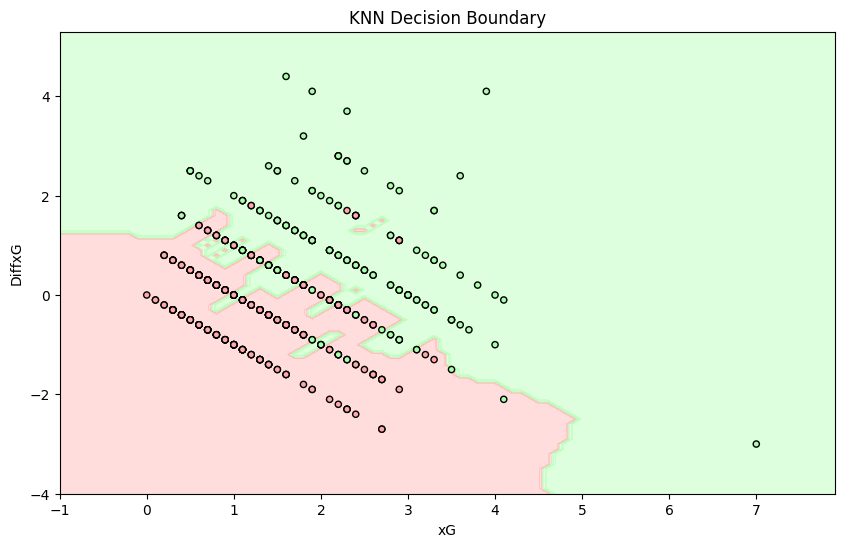

In [13]:
test_data_df = pd.DataFrame({
    'xG': [9.6],
    'DiffxG': [-0.6]
})

predicted_result = knn.predict(test_data_df)
print(f"Predicted Result: {predicted_result[0]}")

# Define plot boundaries
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

# Generate a grid of points to plot decision boundary
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the labels for all points in the grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Define colors for the contour plot
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

# Plot decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_light, s=20, edgecolors='k')
plt.xlabel('xG')
plt.ylabel('DiffxG')
plt.title('KNN Decision Boundary')
plt.show()

Conclusion